# Text Classification Problem
Classification of 4 types of texts (Sports, World, Business, Science/Technology)

# Data Preparation
The [training data](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?select=train.csv) contains 120000 samples of news articles.
The algorithm will be trained to predict the labels for test texts:
- 1 - World
- 2 - Sports
- 3 - Business
- 4 - Science/Technology


In [205]:
classes = ["World", "Sports", "Business", "Science/Technology"]

Mount Google Drive

In [161]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Libraries

In [202]:
# Basic
import string
import nltk
import numpy as np
import pandas as pd

# Visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Scickit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf

# Loading in Dataframe

In [206]:
df = pd.read_csv('./drive/MyDrive/text-classification/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Merge title and description in one column and give label

In [207]:
df['label'] = df['Class Index'].apply(lambda idx: classes[idx - 1])
df['text'] = df['Title'].astype(str) + ". " + df['Description']
df.drop(['Class Index', 'Title', 'Description'], axis=1, inplace=True)

# Data Exploration

In [208]:
pd.set_option('display.max_colwidth', None)
df.sample(10)

,label,text
58151,Sports,GOLF: SCOTT #39;S TO HAVE TEE WITH ERNIE. SCOTT DRUMMOND has been handed the task of taking on No.1 seed Ernie Els in the first round of the HSBC World Matchplay Championship at Wentworth on Thursday.
67709,Science/Technology,"Ebay Explodes to Twice Its Size. Executives at eBay apologized to frustrated customers who were frozen out of the online auction #39;s payment transaction service, which experienced at least five days of intermittent failures earlier this month."
17203,Sports,"Liuzzi to test for Sauber. Sauber Petronas have invited Vitantonio Liuzzi for a test drive. The 22-year old Red Bull Junior Team pilot, who has won this year #39;s Formula 3000 Championship far ahead of the competition, will be driving the Sauber Petronas C23 at Jerez on 16 September."
22839,Science/Technology,"RealNetworks Sells 3 Mln Songs, Ends Download Promo (Reuters). Reuters - RealNetworks Inc. is ending\its 49 cent-per-song music download service but will keep the\promotional prices in place for top 10 songs, the Internet\media and software company said on Thursday."
31181,Science/Technology,FTC Assesses Bounty System for Catching Spammers. The FTC today issued a report assessing whether and how a system that rewards members of the public for tracking down spammers would or could help improve enforcement of the Controlling the Assault of Non-Solicited Pornography and Marketing Act of 2002
119436,World,"Bug found at UN Geneva HQ. GENEVA, DECEMBER 17: The United Nations said on Thursday a secret listening device had been found in a posh meeting room of its European headquarters in Geneva."
71841,Business,"NY Gold Ends Near \$430. NEW YORK (Reuters) - COMEX gold futures closed at fresh 6-1/2-month highs on Monday as investors bought the safe-haven metal due to an ailing dollar, soaring oil prices and uncertainty over the U.S. presidential election, dealers said."
71032,Science/Technology,RFID cell phones take shape at Nokia. The cell phone maker is working on a phone that uses controversial microchips used to store product information and signal their location.
18882,World,"India and Pakistan agree to widen peace dialogue . NEW DELHI -- Nuclear rivals India and Pakistan agreed yesterday to widen their peace dialogue in talks that focused on eight festering issues, including the decades-old dispute over the Himalayan region of Kashmir."
8522,World,"Hicks to be reunited with father. ELEANOR HALL: After close to three years in US detention, Australian Guantanamo Bay detainee, David Hicks, will shortly be reunited with his father, Terry, whos on his way to Cuba to attend his son #39;s trial before a US military commission."


# Text Preprocessor

Create Text Preprocessor

In [209]:
nltk.download('stopwords')
nltk.download('punkt')

class TextPreprocessor:
    def __init__(self, language="english", use_lemmatization=False, use_stemming=True):
        self.language = language
        self.use_stemming = use_stemming
        self.use_lemmatization = use_lemmatization
        self.__setup_default_language()

    @staticmethod
    def __tokenize_text(text):
        words = nltk.tokenize.word_tokenize(text.lower())
        return list(filter(lambda word: word not in string.punctuation, words))

    def __setup_default_language(self):
        self.stop_words = set(nltk.corpus.stopwords.words(self.language))
        if self.use_stemming:
            self.stemmer = nltk.stem.PorterStemmer()
            self.stem = self.stemmer.stem
        if self.use_lemmatization:
            self.lemmatizer = nltk.stem.WordNetLemmatizer()
            self.lemmatize = self.lemmatizer.lemmatize
            self.stemmer = nltk.stem.PorterStemmer()

    def __remove_stopwords(self, words):
        return list(filter(lambda word: word not in self.stop_words, words))

    def __stem_words(self, words):
        return map(self.stem, words)

    def __lemmatize_words(self, words):
        return map(self.lemmatize, words)

    def preprocess(self, text):
        """Preprocess the input text.

        Tokenizes the text, removes stopwords, and optionally performs lemmatization and/or stemming.

        Args:
            text (str): The input text to be preprocessed.

        Returns:
            str: The preprocessed text.
        """
        tokens = self.__tokenize_text(text)
        tokens = self.__remove_stopwords(tokens)
        if self.use_lemmatization:
            tokens = self.__lemmatize_words(tokens)
        if self.use_stemming:
            tokens = self.__stem_words(tokens)
        return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Apply Text Preprocessor to dataframe

In [210]:
text_preprocessor = TextPreprocessor()
df['text'] = df['text'].apply(lambda txt: text_preprocessor.preprocess(txt))
df.sample(5)

,label,text
51885,Business,eu take us wto follow move airbu aid european commiss said wednesday seek consult unit state world trade organis respons us action state aid european aircraft maker airbu
67478,Science/Technology,text alert hk emerg new scheme allow disabl peopl summon emerg servic text messag launch hong kong
69484,Sports,baird lead mickey mous club lake buena vista 39 true noth put smile face trip disney world doubt take look week 39 funai classic leader board
102463,World,bush work peac northern ireland crawford texa presid bush say 39 quot anyth quot help keep northern ireland peac process move forward
11291,Sports,china 39 guo easili win 3m springboard name may chang result china still rule olymp dive pool chines earn anoth gold medal fifth athen game guo jingj


# Train Test Split

In [212]:
X_train, X_temp = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)

labels_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size = 0.5, stratify = labels_test_val, random_state = 42)

print(f'The shape of train data {X_train.shape}')
print(f'The shape of test data {X_test.shape}')
print(f'The shape of validation data {X_val.shape}')

The shape of train data (96000, 2)
The shape of test data (12000, 2)
The shape of validation data (12000, 2)


Сreate a barplot to see the class distribution.

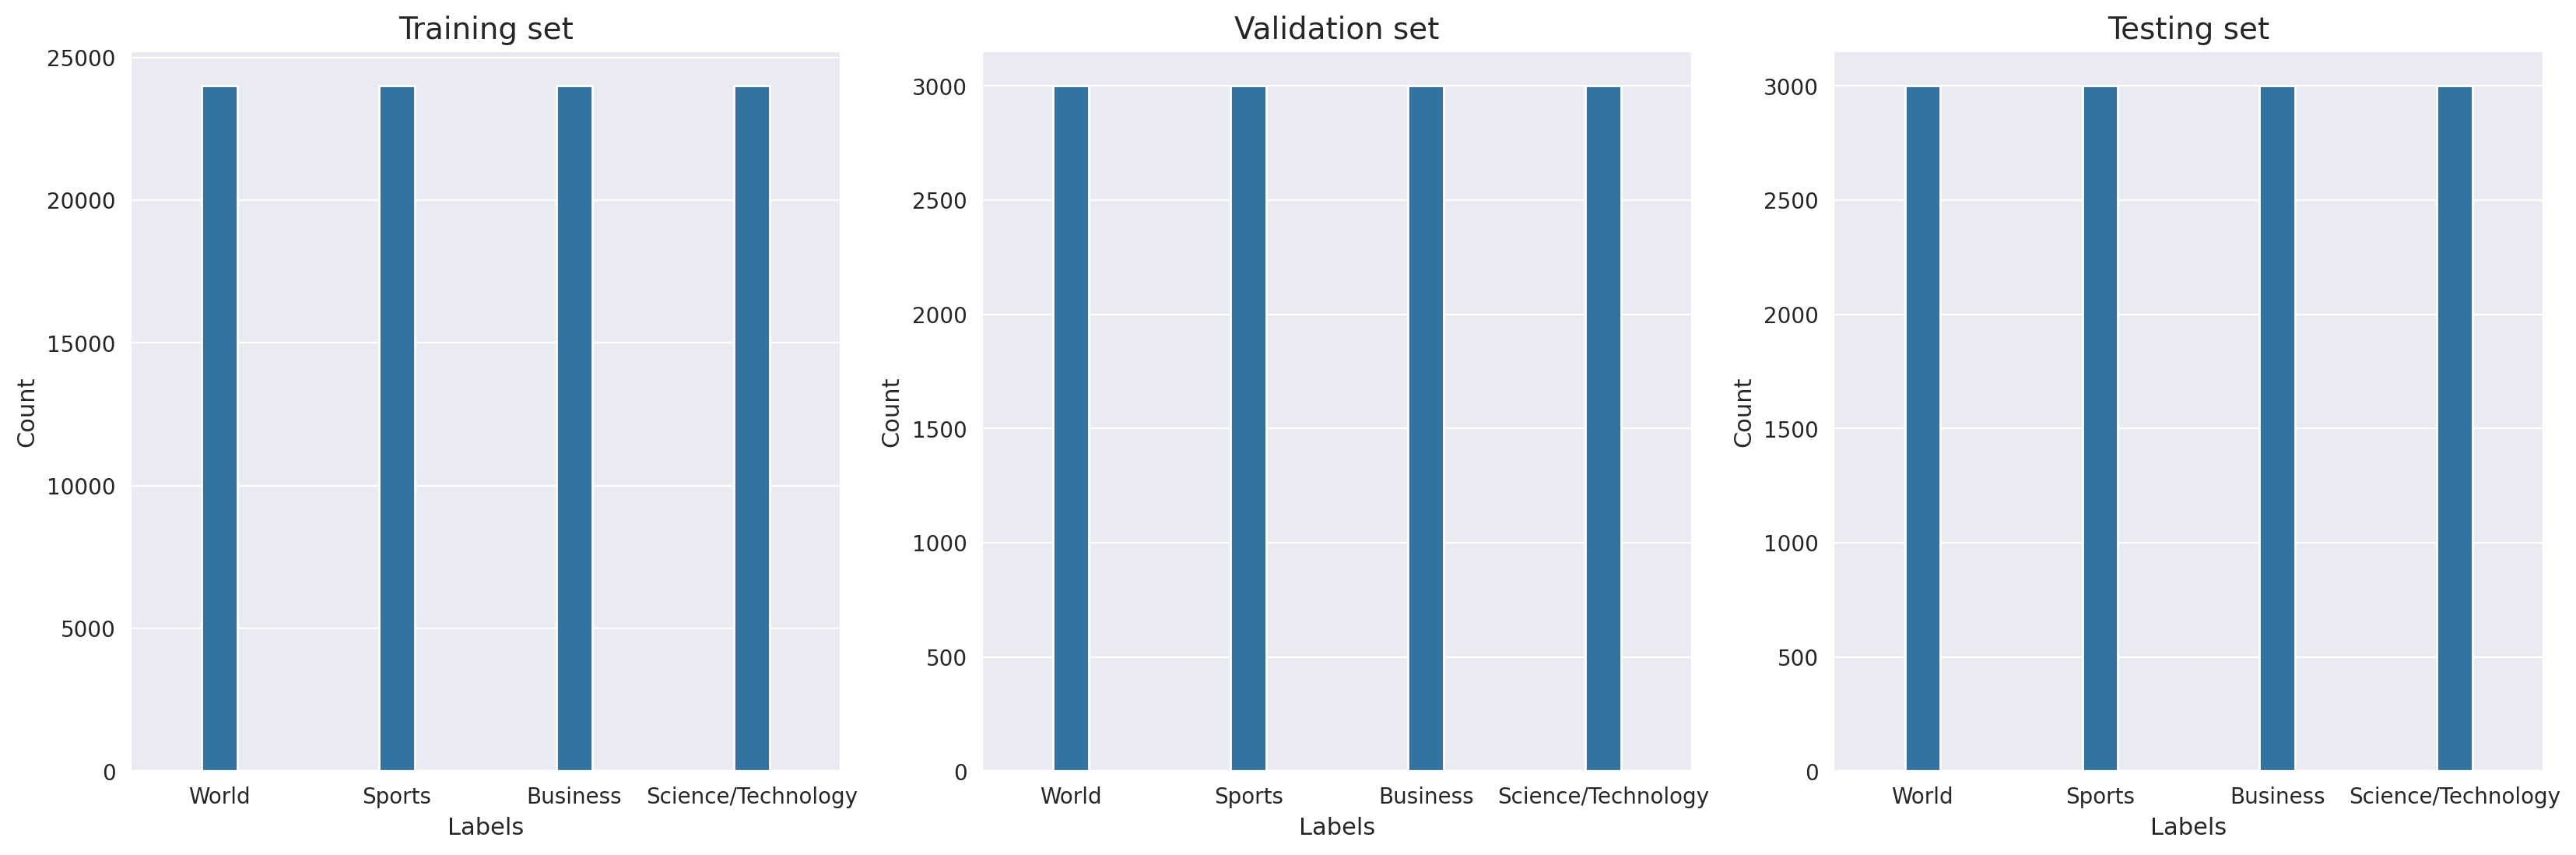

In [213]:
label1, count1 = np.unique(X_train.label,return_counts=True)
label2, count2 = np.unique(X_val.label,return_counts=True)
label3, count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=classes,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=classes,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=classes,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',width=0.2).set_title('Training set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',width=0.2).set_title('Validation set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',width=0.2).set_title('Testing set',fontsize=14)
plt.xlabel('Labels',fontsize=11)
plt.ylabel('Count',fontsize=11)

plt.show()

# Model

Create dataset

In [214]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

categories = X_train['label'].astype('category').cat.categories.tolist()

train_ds = tf.data.Dataset.from_tensor_slices((X_train['text'].to_numpy(), X_train['label'].astype('category').cat.codes))
valid_ds = tf.data.Dataset.from_tensor_slices((X_val['text'].to_numpy(), X_val['label'].astype('category').cat.codes))
test_ds = tf.data.Dataset.from_tensor_slices((X_test['text'].to_numpy(), X_test['label'].astype('category').cat.codes))

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Create the text encoder

In [216]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())


Create model

In [217]:
EMBEDDING_DIM = 64
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),
    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation="softmax") # Softmax activation for multiclass classification
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_10 (Tex  (None, None)              0         
 tVectorization)                                                 
                                                                 
 embedding_12 (Embedding)    (None, None, 64)          320000    
                                                                 
 bidirectional_12 (Bidirect  (None, 128)               66048     
 ional)                                                          
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 4)                 260       
                                                                 
Total params: 394564 (1.51 MB)
Trainable params: 3945

# Callbacks
ReduceLROnPlateau - reduces training rate when the metric stops improving

In [218]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            partience=2,
                                            factor=0.5,
                                            min_lr=0.00001,
                                            verbose=1)

# Compile the Model
- Optimizer: Adam(default)
- Loss: Categorical Crossentropy
- Metrics: Accuracy

In [219]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# Fit the Model

We are now going to train our compiled model. The model will be trained for 5 epochs.

In [220]:
model_history = model.fit(train_ds,
                          validation_data=valid_ds,
                          callbacks=[learning_rate_reduction],
                          epochs=5)

Epoch 1/5
1500/1500 [==============================] - 153s 93ms/step - loss: 0.7386 - accuracy: 0.7012 - val_loss: 0.3847 - val_accuracy: 0.8743 - lr: 1.0000e-04
Epoch 2/5
1500/1500 [==============================] - 148s 98ms/step - loss: 0.3386 - accuracy: 0.8887 - val_loss: 0.3168 - val_accuracy: 0.8964 - lr: 1.0000e-04
Epoch 3/5
1500/1500 [==============================] - 145s 96ms/step - loss: 0.2885 - accuracy: 0.9061 - val_loss: 0.3043 - val_accuracy: 0.9004 - lr: 1.0000e-04
Epoch 4/5
1500/1500 [==============================] - 142s 95ms/step - loss: 0.2620 - accuracy: 0.9147 - val_loss: 0.2872 - val_accuracy: 0.9073 - lr: 1.0000e-04
Epoch 5/5
1500/1500 [==============================] - 138s 92ms/step - loss: 0.2384 - accuracy: 0.9218 - val_loss: 0.2788 - val_accuracy: 0.9076 - lr: 1.0000e-04


Plot the result

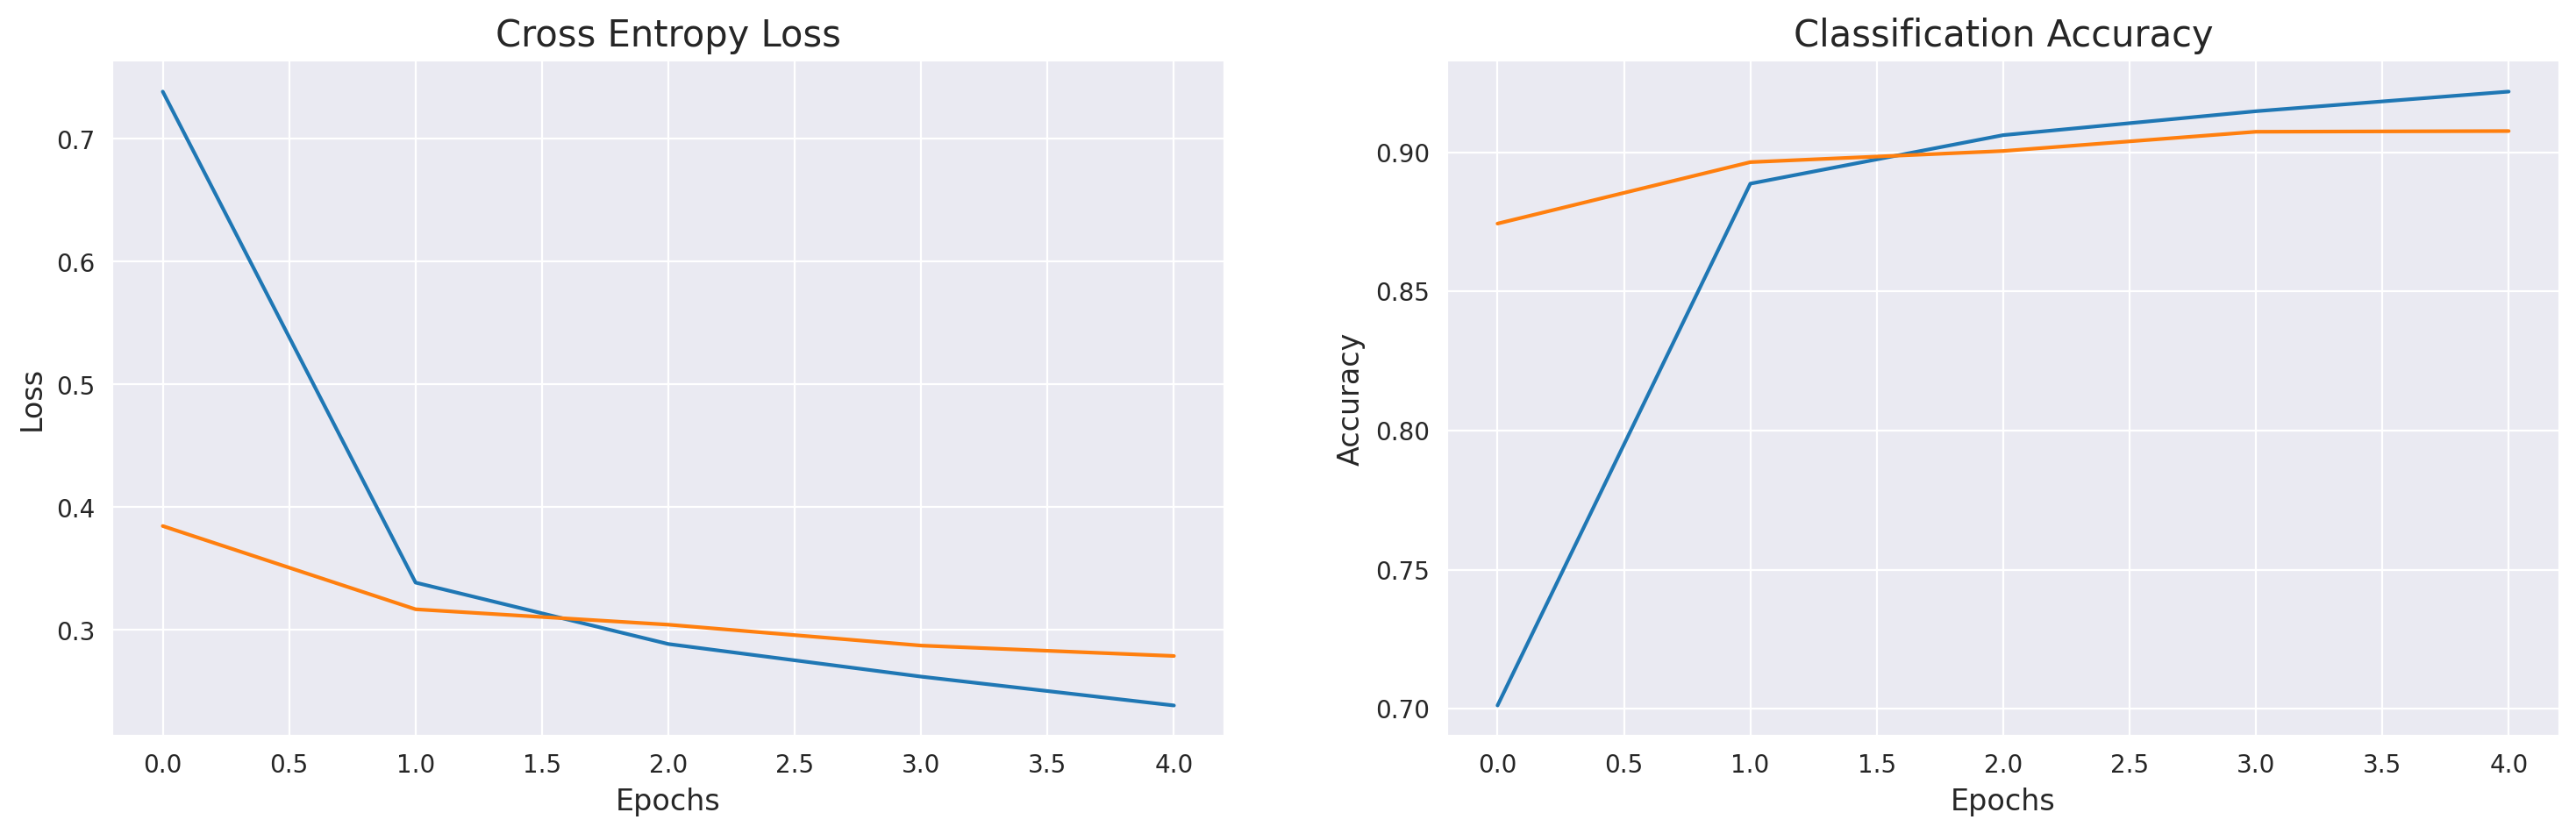

In [221]:
error = pd.DataFrame(model_history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy',fontsize=12)

plt.plot(error ['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

# Evaluation

In [222]:
loss, acc = model.evaluate(train_ds)
print('The accuracy of the model for training data is: ', acc*100)
print('The loss of the model for training data is:', loss)

loss, acc = model.evaluate(valid_ds)
print('The accuracy of the model for validation data is:', acc*100)
print('The loss of the model for validation data is:', loss)

1500/1500 [==============================] - 43s 29ms/step - loss: 0.2177 - accuracy: 0.9301
The accuracy of the model for training data is:  93.0093765258789
The loss of the model for training data is: 0.21770401298999786
188/188 [==============================] - 6s 33ms/step - loss: 0.2788 - accuracy: 0.9076
The accuracy of the model for validation data is: 90.75833559036255
The loss of the model for validation data is: 0.2787620425224304


Save the model

In [223]:
model.save("model.keras")

# Prediction

In [224]:
result = model.predict(test_ds)

y_pred = np.argmax(result, axis = 1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)
loss, acc = model.evaluate(test_ds)

print('The accuracy of the model for testing data is:', acc*100)
print('The loss of the model for testing data is:', loss)

188/188 [==============================] - 7s 35ms/step - loss: 0.2800 - accuracy: 0.9066
The accuracy of the model for testing data is: 90.6583309173584
The loss of the model for testing data is: 0.2800160348415375


Classification report

In [225]:
print(classification_report(y_true, y_pred, target_names = classes))

                    precision    recall  f1-score   support

             World       0.87      0.88      0.88      3000
            Sports       0.89      0.88      0.88      3000
          Business       0.95      0.97      0.96      3000
Science/Technology       0.91      0.90      0.90      3000

          accuracy                           0.91     12000
         macro avg       0.91      0.91      0.91     12000
      weighted avg       0.91      0.91      0.91     12000



Confusion matrix

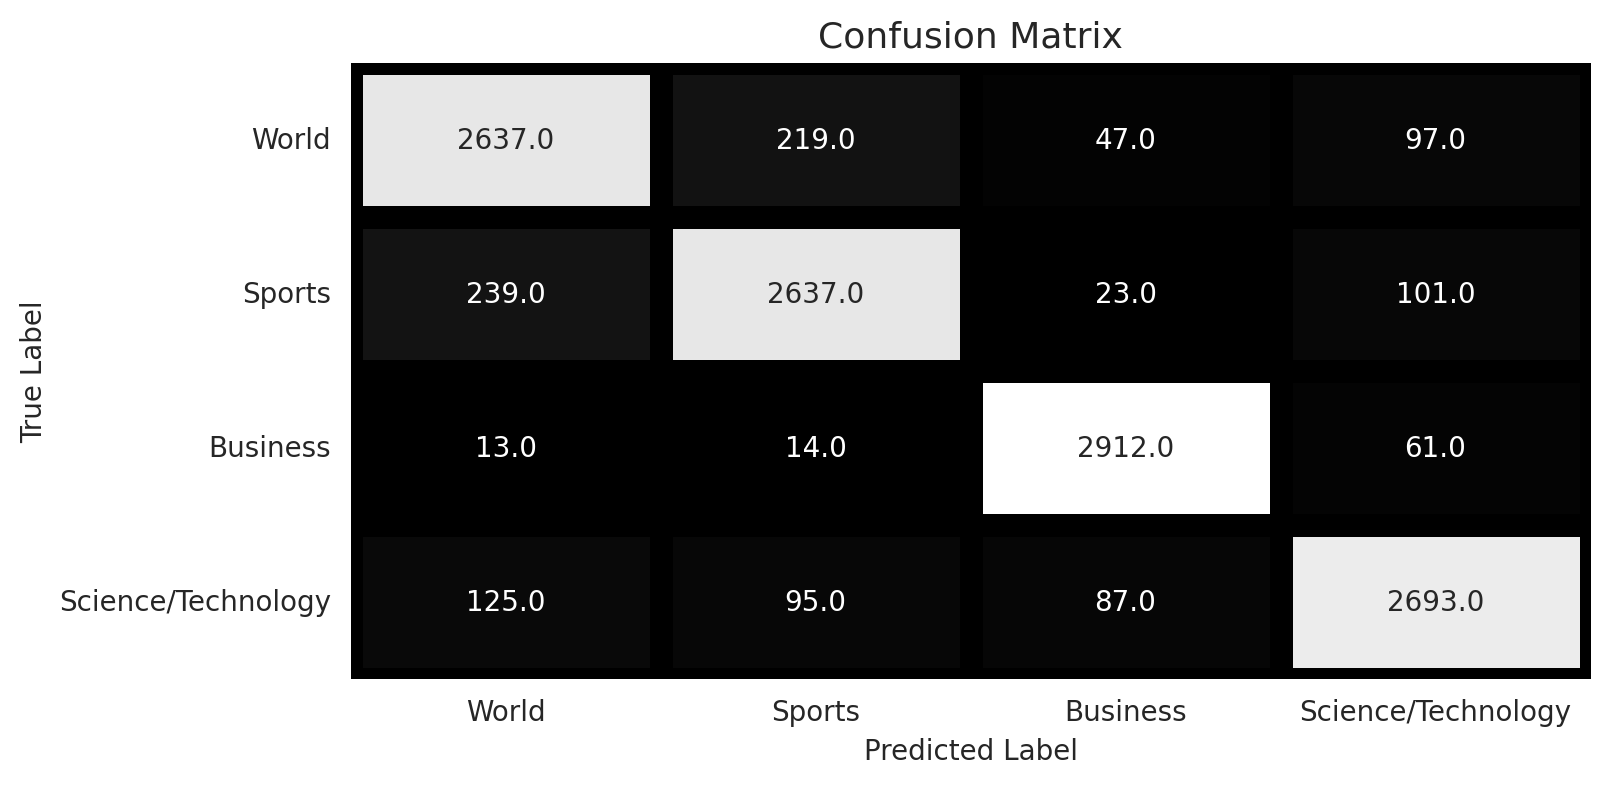

In [226]:
confusion_mtx = confusion_matrix(y_true, y_pred)

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx,
            annot=True,
            linewidths=8.1,
            cmap="gist_yarg_r",
            linecolor="black",
            fmt=".1f",
            ax=ax,
            cbar=False,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)

plt.title("Confusion Matrix", fontsize=13)

plt.show()

Check classification on random samples

In [231]:
sample_text = """
In the realm of technology, artificial intelligence (AI) stands as a revolutionary force, reshaping industries, augmenting human capabilities, and fueling innovation.
Through advanced algorithms and computational power, AI systems can analyze vast datasets, recognize patterns, and make autonomous decisions with unprecedented accuracy and efficiency.
From virtual assistants streamlining daily tasks to self-driving cars navigating complex environments, the potential applications of AI are vast and continually expanding.
While unlocking new possibilities, AI also raises ethical and societal considerations, prompting discussions on privacy, bias, and the future of work in an increasingly automated world.
"""

# Preprocess the text sample (replace this with your actual preprocessing steps)
processed_text =  text_preprocessor.preprocess(sample_text)
print(processed_text)

# Make predictions
predictions = model.predict(np.array([processed_text]))

predicted_probabilities = predictions[0]
# Create a list of tuples containing category index and probability
category_prob_tuples = [(i, prob) for i, prob in enumerate(predicted_probabilities)]
# Sort the list of tuples by probability in descending order
sorted_category_prob_tuples = sorted(category_prob_tuples, key=lambda x: x[1], reverse=True)
# Display the results
for i, (category_index, probability) in enumerate(sorted_category_prob_tuples):
    print(f"{i+1}. Category: {categories[category_index]}, Probability: {probability}")

realm technolog artifici intellig ai stand revolutionari forc reshap industri augment human capabl fuel innov advanc algorithm comput power ai system analyz vast dataset recogn pattern make autonom decis unpreced accuraci effici virtual assist streamlin daili task self-driv car navig complex environ potenti applic ai vast continu expand unlock new possibl ai also rais ethic societ consider prompt discuss privaci bia futur work increasingli autom world
1/1 [==============================] - 0s 54ms/step
1. Category: Science/Technology, Probability: 0.9925069212913513
2. Category: Business, Probability: 0.00653393380343914
3. Category: World, Probability: 0.0009525039349682629
4. Category: Sports, Probability: 6.58412091070204e-06
